In [204]:
import numpy as np
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._backward = lambda: None
        self._prev = _children
        self.grad = .0
        self._op = _op
        self.label=label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1. * out.grad
            other.grad += 1. * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other 

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward

        return out
    
    def relu(self):
        out = Value(max(self.data,0), tuple([self]), 'relu')

        def _backward():
            self.grad += 1 * out.grad if self.data > 0 else 0
        
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * (other**(-1))

    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data**other.data, (self, other), 'pow')
        def _backward():
            self.grad += other.data * (self.data**(other.data - 1)) * out.grad
            other.grad += self.data**other.data * math.log(self.data) * out.grad
        out._backward = _backward

        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(node):
            visited.add(node)
            for child in node._prev:
                build_topo(child)
            topo.append(node)
            
        build_topo(self)
        self.grad=1.
        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f'{self.label} = {self.data}\t'

    

In [205]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

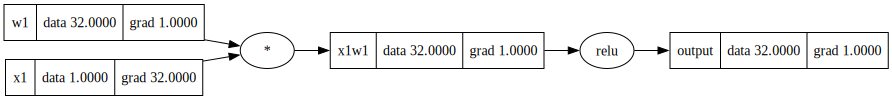

In [206]:
a = Value(1, label='x1')
b = Value(32, label='w1')
c = a*b; c.label='x1w1'
k = c.relu(); k.label = 'output'
k.backward()
draw_dot(k)

In [271]:
import numpy as np
class Tensor():
    def __init__(self, data: np.ndarray, children = (), _op='', label = ''):
        data = np.array(data)
        self._op = _op 
        self.shape = data.shape
        self.data = data 
        self.label = label
        self._prev = children
        self.grad = np.zeros(self.shape)
        self._backward = lambda : None


    def matmul(self, other):
        out = Tensor(data=np.matmul(self.data,other.data), children=(self,other), _op='matmul')
        
        def _backward():
            self.grad += np.matmul(out.grad, np.transpose(other.data))
            other.grad += np.matmul(np.transpose(self.data), out.grad)
        
        out._backward = _backward

        return out

    def __repr__(self):
        if len(self.shape) == 2:
            s = ''
            for row in self.data:
                s = s + str(row) + '\n'
            return s
        else:
            return str(self.data)
    
    

In [272]:
a = Tensor(np.array([4211,43])); a.label = 'a'
b = Tensor(np.array([[1,4],[12,3]])); b.label = 'b'

c = a.matmul(b); c.label = 'c'

In [273]:
np.array([4211,43]).shape

(2,)

In [274]:
a

[4211   43]

In [259]:
a.grad

array([0., 0.])

In [260]:
b

[1 4]
[12  3]

In [261]:
b.grad

array([[0., 0.],
       [0., 0.]])

In [263]:
c.grad = np.ones(c.shape)
c._backward()

In [264]:
a.grad

array([ 5., 15.])

In [265]:
b.grad

array([[4254., 4254.],
       [4254., 4254.]])

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        label = '''<
        <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
          <TR>
            <TD COLSPAN="2">{label}</TD>
          </TR>
          <TR>
            <TD>data</TD>
            <TD>grad</TD>
          </TR>
          <TR>
            <TD>{data}</TD>
            <TD>{grad}</TD>
          </TR>
        </TABLE>>'''.format(label=n.label if hasattr(n, 'label') else '', 
                           data=n.data if hasattr(n, 'data') else '', 
                           grad=n.grad if hasattr(n, 'grad') else '')
        
        dot.node(name=str(id(n)), label=label, shape='plaintext')
        
        if hasattr(n, '_op') and n._op:
            # Style the operation node differently
            dot.node(name=str(id(n)) + n._op, label=n._op, 
                    shape='ellipse', style='filled', fillcolor='lightgray')
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        if hasattr(n2, '_op') and n2._op:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        else:
            dot.edge(str(id(n1)), str(id(n2)))
    
    return dot

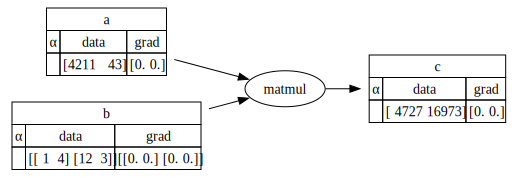

In [299]:
draw_dot(c)